In [1]:
"""
This notebook reads GEOSCCM ice, GEOSCCM trajectory evaporation rate data, 
and other GEOSCCM and GEOSCCM trajectory data.
It also processes the GEOSCCM and GEOSCCM trajectory data to get RH and convective moistening
Then we plot the data.
"""

'\nThis notebook reads GEOSCCM ice, GEOSCCM trajectory evaporation rate data, \nand other GEOSCCM and GEOSCCM trajectory data.\nIt also processes the GEOSCCM and GEOSCCM trajectory data to get RH and convective moistening\nThen we plot the data.\n'

In [2]:
import numpy as np
import pandas as pd
import xarray as xr 
from seasonal_cycle_analysis_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
degree_sign= u'\N{DEGREE SIGN}'
from string import ascii_lowercase
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
indir = '/mnt/data/ice2/xwang/ACP2019_data_code/data/'

#--- specify file names to read
fname = ['geosccm_icemix.nc',\
         'geosccm_Traj_evaprate.nc',\
         'geosccm_temperature.nc',\
         'geosccm_h2omix_no-avk.nc',\
         'geosccm_TrajStandard_h2omix_no-avk.nc',\
         'geosccm_TrajIce_h2omix_no-avk.nc']

#--- define arrays to store data
nfile = 6
nmonth = 12
nlat = 45
var = np.zeros((nfile,nmonth,nlat)) # stores zonal mean seasonal cycle for each variable

#--- begin reading data from file
#--- first define a function to help process the data
def read_data(fname,time1,time2,pr):
    ff=xr.open_dataset(fname)
    ff['time']=pd.to_datetime(ff.time, format='%Y%m')
    if pr >0: 
        ff = ff.sel(pressure=pr,method='nearest').sel(time=slice(time1,time2)).groupby('time.month').mean(dim='time').mean(dim='longitude')
    else:
        ff = ff.sel(time=slice(time1,time2)).groupby('time.month').mean(dim='time').mean(dim='longitude')
    return ff

#--- read and process data
ff = read_data(indir+fname[0],'2004-08-01','2018-10-31',100) # get geosccm convective ice
var[0,:] = ff.ice_mix.values

ff = read_data(indir+fname[1],'2004-08-01','2018-10-31',100) # get geosccm trajectory ice evaporation rate
var[1,:] = ff.evap_rate.values

ff = read_data(indir+fname[2],'2004-08-01','2018-10-31',100) # get geosccm temperature 
var[2,:] = ff.temperature.values    

ff = read_data(indir+fname[3],'2004-08-01','2018-10-31',0)  # get geosccm water vapor
var[3,:] = ff.h2o_mix.values 

ff = read_data(indir+fname[4],'2004-08-01','2018-10-31',0)  # get geosccm standard trajectory water vapor
var[4,:] = ff.h2o_mix.values 

ff = read_data(indir+fname[5],'2004-08-01','2018-10-31',0)  # get geosccm ice model water vapor
var[5,:] = ff.h2o_mix.values 
lat = ff.latitude.values

#--- Now generate the variables we are going to plot
#--- We need geosccm convective ice, geosccm evaporation rate,
#--- geosccm RH, and geosccm trajectory convective moistening.
#--- We already have geosccm convective ice and geosccm evaporation rate,
#--- all we need is to generate geosccm RH and geosccm trajectory convective moistening.
nvar = 4
var2 = np.zeros((nvar,nmonth,nlat))                       # stores the new variables to be plotted
var2[:2,:] = var[:2,:]*1.
sat_h2o = sat_mix_mk(np.ones_like(var[2,:])*100,var[2,:]) # get the saturation mixing ratio
var2[2,:] = var[3,:]/sat_h2o*100                          # get the RH
var2[3,:] = var[5,:]-var[4,:]                             # get the geosccm trajectory convective moistening



# Begin plotting the figure

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


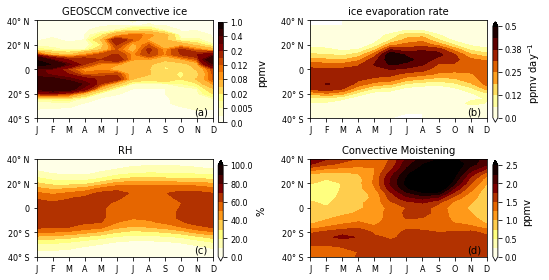

In [5]:
#--- pre-define some variables to aid the plotting
vmax = [[0.1,0.5],[100,2.5]]
vmin = [[0,0],[0,0]]
nlvl = [[11,9],[11,11]]
lattick = [-40,-20,0,20,40]
lontick = [0,120,240,360]
colorbari = [[5,5],[6,6]]
cbar_x = [0.44,0.985]
cbar_y = [0.56,0.078]
xt = np.arange(1,13,1)

title = ['GEOSCCM convective ice','ice evaporation rate','RH','Convective Moistening']
cbar_label = ['ppmv',r'ppmv day$^{-1}$','%','ppmv']
latstr = ['40'+degree_sign+' S','20'+degree_sign+' S','0','20'+degree_sign+' N','40'+degree_sign+' N']
xtk = np.array([calendar.month_abbr[i][0] for i in xt]) 

#--- Start plotting
fig,ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(7,4, forward=True)
k = 0

for i in range(2):       
    for j in range(2):
        ax[i][j].set_yticks(lattick) 
        ax[i][j].set_yticklabels(latstr,fontsize=8)       
        ax[i][j].set_xticks(xt)
        ax[i][j].set_xticklabels(xtk,fontsize=8)
        ax[i][j].set_ylim([-40,40])
        ax[i][j].set_title(title[k],fontsize=10)
        ax[i][j].annotate('('+ascii_lowercase[k]+')',xy=(0.97,0.02),\
                          xycoords='axes fraction',size=10,ha='right',va='bottom')
        if i == 0 and j ==0:
            pass
        else:
            leveli = np.linspace(vmin[i][j],vmax[i][j],nlvl[i][j]) 
            # first plot evaporation rate, RH, and convective moistening
            ima = ax[i][j].contourf(xt,lat,var2[k,:].T,cmap='afmhot_r',\
                                    levels=leveli,extend='both') 
            cbaxes = fig.add_axes([cbar_x[j],cbar_y[i],0.01,0.35])    
            colorbar_setting(fig,ima,ax[i][j],vmin[i][j],vmax[i][j],colorbari[i][j],cbar_label[k],cbaxes)
        k+=1

# then plot convective ice      
leveli = np.array([0,1e-4,0.005,0.01,0.02,0.04,0.08,0.1,0.12,0.15,0.2,0.3,0.4,0.8,1.])
ima = ax[0][0].contourf(xt,lat,var2[0,:].T,cmap='afmhot_r',levels = leveli,norm=PiecewiseNorm(leveli))

cbaxes = fig.add_axes([cbar_x[0],cbar_y[0],0.01,0.35])    
cbl = fig.colorbar(ima, ax=ax[0][0],cax=cbaxes)
cbl.set_label('ppmv',fontsize=10) 
cticks = leveli[::2]
cbl.set_ticks(cticks)
clabels = np.array([np.str(round(i,3)) for i in cticks])
cbl.set_ticklabels(clabels)
cbl.ax.tick_params(labelsize=8) 

plt.tight_layout(w_pad=6.5)
